In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name, has_lable):
    path = os.path.join("data", name)
    data = pd.read_csv(path)
    data = data.values
    if has_lable:
        xs = data[:, 1:].astype('float32')
        ys = data[:, 0]
        return xs, ys
    else:
        return data

In [3]:
dataset_blobs = load_dataset("blobs.csv", False)

In [4]:
def draw_points(xs, ys, title=None):
    n = len(xs)
    k = np.max(ys) + 1
    
    clusters = {}
    for i in range(n):
        x = xs[i]
        y = ys[i]
        clusters[y] = clusters.get(y, [])
        clusters[y].append(x)
    
    if -1 in clusters:
        clusters[-1] = np.array(clusters[-1])
        xs, ys = clusters[-1][:, 0], clusters[-1][:, 1]
        xs, ys = xs.tolist(), ys.tolist()
        plt.plot(xs, ys, 'ro', c='black')
    
    color=iter(plt.cm.rainbow(np.linspace(0,1,k)))
    for i in range(k):
        clusters[i] = np.array(clusters[i])
        xs, ys = clusters[i][:, 0], clusters[i][:, 1]
        xs, ys = xs.tolist(), ys.tolist()
        plt.plot(xs, ys, 'ro', c=next(color))
        
    if title is not None:
        plt.title(title)
    plt.show()

In [5]:
def get_nearest_points(xs, ys):
    dsts = np.sum((xs[None, :, :] - ys[:, None, :]) ** 2, axis=-1)
    return np.argmin(dsts, axis=0)

def k_means(xs, k):
    n = xs.shape[0]
    dim = xs.shape[1]
    
    cs = np.zeros((k, dim))
    init_indxs = np.random.choice(range(n), k, replace=False)
    cs_new = xs[init_indxs]
    while not np.allclose(cs, cs_new):
        cs = cs_new.copy()
        indxs = get_nearest_points(xs, cs)
        for i in range(k):
            mask = (indxs == i)[:, None]
            cs_new[i] = np.sum(xs * mask, axis=0) / np.sum(mask)
            
    return cs

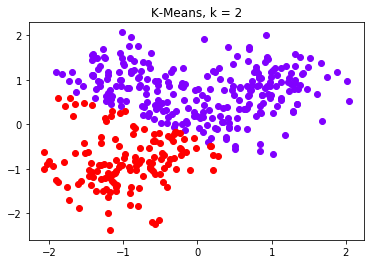

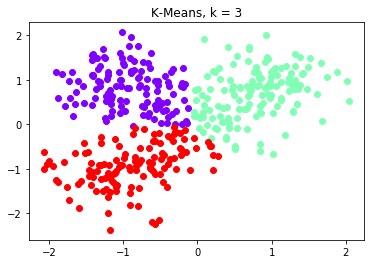

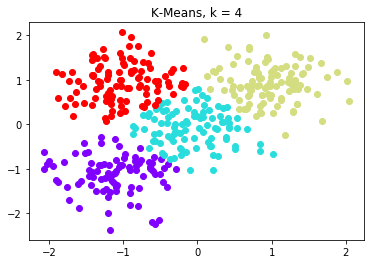

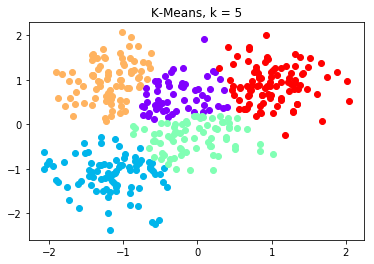

In [6]:
ks = list(range(2, 6))
for k in ks:
    centers = k_means(dataset_blobs, k)
    indexes = get_nearest_points(dataset_blobs, centers)
    draw_points(dataset_blobs, indexes, 'K-Means, k = {}'.format(k))

In [7]:
def DBSCAN(xs, eps, m):    
    def get_neighbors(x):
        dsts = np.sum((xs - x) ** 2, axis=-1)
        return np.argwhere(dsts < eps).reshape(-1)
    
    n = len(xs)
    neighbors = [get_neighbors(xs[i]) for i in range(n)]
    is_main = [len(neighbors[i]) >= m for i in range(n)]
    mp = set(list(filter(lambda i: is_main[i], range(n))))
    dp = set(list(filter(lambda i: not is_main[i], range(n))))
    
    cmp = [-1 for _ in range(n)]
    def dfs(i, c):
        if i not in mp:
            return
        if cmp[i] == c:
            return
        cmp[i] = c
        for j in neighbors[i]:
            dfs(j, c)
        
    c = 0
    for i in mp:
        if cmp[i] == -1:
            dfs(i, c)
            c += 1
            
    for i in dp:
        min_d = 10 ** 8
        for j in neighbors[i]:
            if j in dp:
                continue
            d = np.sum((xs[i] - xs[j]) ** 2)
            if min_d < d:
                min_d = d
                cmp[i] = cmp[j]
                
    return np.array(cmp)

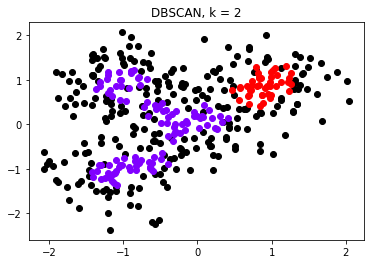

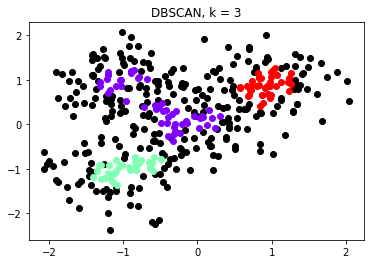

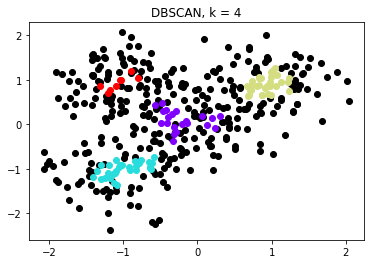

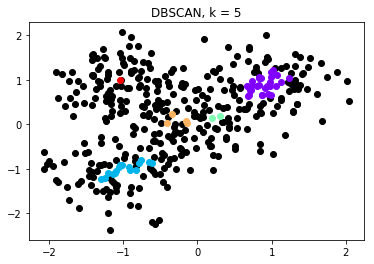

In [8]:
ks = set(list(range(2, 6)))

clss = {}
for eps in np.arange(0.1, 1, 0.1):
    for m in np.arange(10, 30, 1):
        cls = DBSCAN(dataset_blobs, eps, m)
        k = max(cls) + 1
        if (k in ks) and (k not in clss):
            clss[k] = cls
           
for k in ks:
    draw_points(dataset_blobs, clss[k], 'DBSCAN, k = {}'.format(k))

In [9]:
def agglomerative_clustering(xs, k):
    n = len(xs)
    dst = np.sum((xs[None, :, :] - xs[:, None, :]) ** 2, axis=-1)
    dst[np.diag_indices_from(dst)] += 10 ** 8
    cmp_indxs = [[i] for i in range(n)]
    
    for _ in range(n - k):
        i, j = np.unravel_index(np.argmin(dst, axis=None), dst.shape)
        
        cmp_indxs[i] += cmp_indxs[j]
        cmp_indxs = cmp_indxs[:j] + cmp_indxs[j+1:]
        
        r_i = dst[i].reshape((-1, 1))
        r_j = dst[j].reshape((-1, 1))
        r = np.max(np.concatenate((r_i, r_j), axis=1), axis=1)
        dst[i, :] = r
        dst[:, i] = r
        dst = np.delete(dst, j, axis=0)
        dst = np.delete(dst, j, axis=1)
    
    cmp = [None] * n
    for i, ind in enumerate(cmp_indxs):
        for j in ind:
            cmp[j] = i
    return cmp

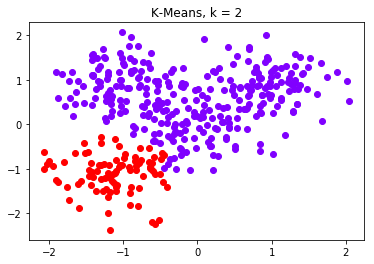

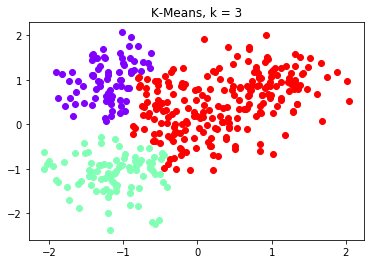

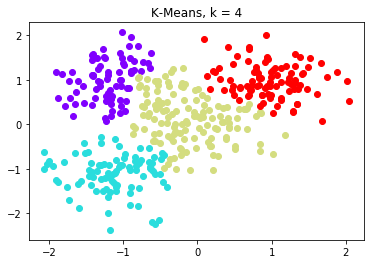

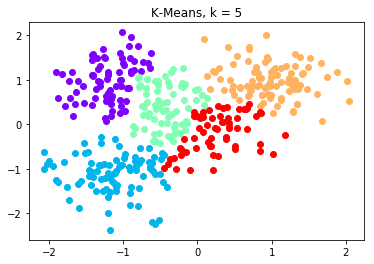

In [10]:
ks = list(range(2, 6))
for k in ks:
    indexes = agglomerative_clustering(dataset_blobs, k)
    draw_points(dataset_blobs, indexes, 'K-Means, k = {}'.format(k))

In [11]:
dataset_cancer = load_dataset("cancer.csv", True)

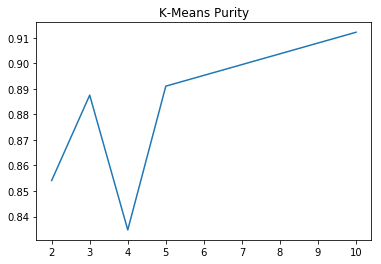

In [12]:
ks = list(range(2, 6)) + [10]
purity = []

for k in ks:
    n = len(dataset_cancer[0])
    centers = k_means(dataset_cancer[0], k)
    indexes = get_nearest_points(dataset_cancer[0], centers)
    
    sm = [{} for _ in range(k)]
    for i in range(n):
        y = indexes[i]
        lable = dataset_cancer[1][i]
        sm[y][lable] = sm[y].get(lable, 0)
        sm[y][lable] += 1
        
    mx = [0 for _ in range(k)]
    for i in range(k):
        for _, s in sm[i].items():
            mx[i] = max(mx[i], s)
            
    purity.append(sum(mx) / n)
    
plt.plot(ks, purity)
plt.title('K-Means Purity')
plt.show()